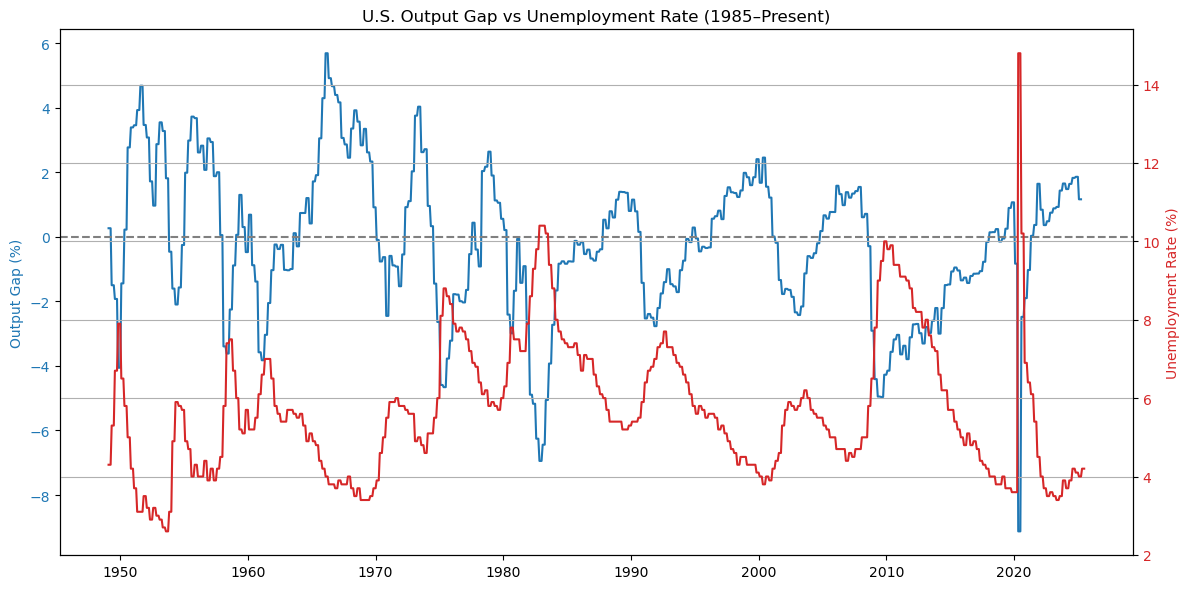

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

start_date = '1949-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# 下载数据
actual_gdp = pdr.DataReader('GDPC1', 'fred', start_date, end_date)
potential_gdp = pdr.DataReader('GDPPOT', 'fred', start_date, end_date)
unrate = pdr.DataReader('UNRATE', 'fred', start_date, end_date)

# 合并数据
df = pd.concat([actual_gdp, potential_gdp], axis=1)
df.columns = ['Actual_GDP', 'Potential_GDP']
df['Output_Gap'] = 100 * (df['Actual_GDP'] - df['Potential_GDP']) / df['Potential_GDP']
df['Unemployment_Rate'] = unrate

# 转换为月度数据
df_monthly = df.resample('M').ffill()

# 可视化：双轴图
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(df_monthly.index, df_monthly['Output_Gap'], label='Output Gap (%)', color='tab:blue')
ax1.set_ylabel('Output Gap (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.axhline(0, color='gray', linestyle='--')

ax2.plot(df_monthly.index, df_monthly['Unemployment_Rate'], label='Unemployment Rate (%)', color='tab:red')
ax2.set_ylabel('Unemployment Rate (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('U.S. Output Gap vs Unemployment Rate (1985–Present)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


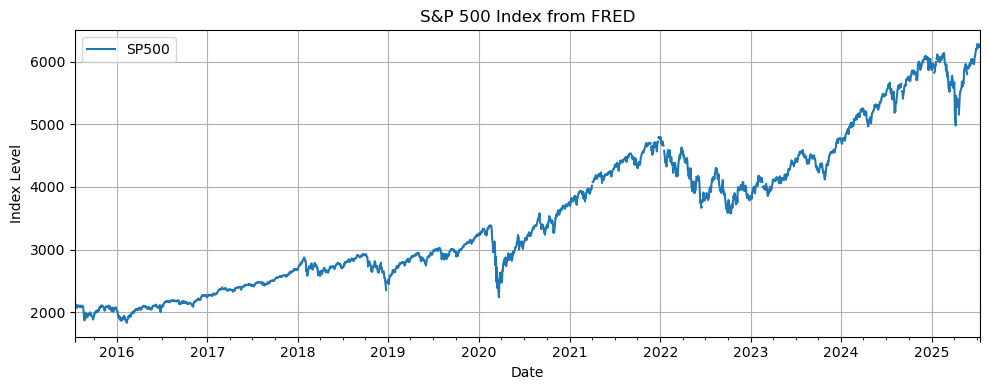

In [2]:
import pandas_datareader.data as pdr
from datetime import datetime
import matplotlib.pyplot as plt

# 设置时间范围
start = '1985-01-01'
end = datetime.today().strftime('%Y-%m-%d')

# 从 FRED 获取 S&P 500 指数（注意：这是月度数据）
sp500 = pdr.DataReader('SP500', 'fred', start, end)

# 可视化
sp500.plot(title='S&P 500 Index from FRED', figsize=(10, 4))
plt.grid(True)
plt.ylabel("Index Level")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

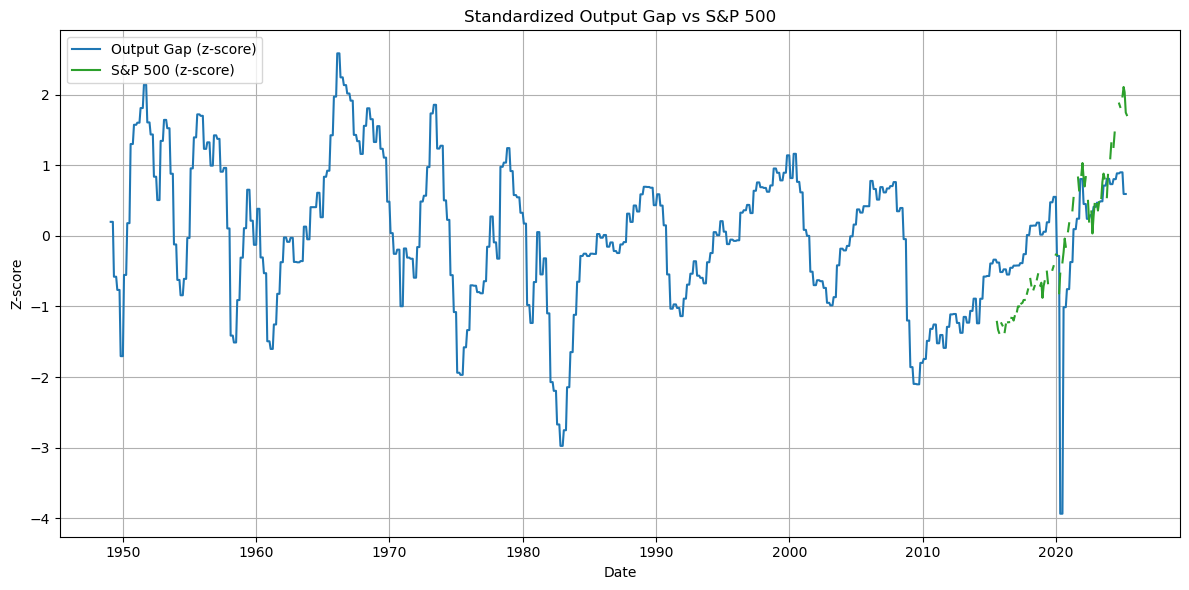

In [16]:
# 合并 S&P 500 到 df_monthly
df_monthly['SP500'] = sp500

from scipy.stats import zscore

# 将 zscore 结果包装成 Series，确保索引匹配
df_monthly['Output_Gap_z'] = pd.Series(zscore(df_monthly['Output_Gap'].dropna()), 
                                       index=df_monthly['Output_Gap'].dropna().index)

df_monthly['SP500_z'] = pd.Series(zscore(df_monthly['SP500'].dropna()), 
                                  index=df_monthly['SP500'].dropna().index)


plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Output_Gap_z'], label='Output Gap (z-score)', color='tab:blue')
plt.plot(df_monthly.index, df_monthly['SP500_z'], label='S&P 500 (z-score)', color='tab:green')
plt.title('Standardized Output Gap vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
import statsmodels.api as sm

# 去除缺失值
df_reg = df_monthly[['SP500_z', 'Output_Gap_z']].dropna()

# 自变量（X）和因变量（Y）
X = df_reg['SP500_z']
y = df_reg['Output_Gap_z']

# 添加常数项（intercept）
X = sm.add_constant(X)

# 拟合 OLS 模型
model = sm.OLS(y, X).fit()

# 打印回归结果
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Output_Gap_z   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     30.12
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           4.43e-07
Time:                        15:16:26   Log-Likelihood:                -86.910
No. Observations:                  84   AIC:                             177.8
Df Residuals:                      82   BIC:                             182.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0335      0.075      0.445      0.6

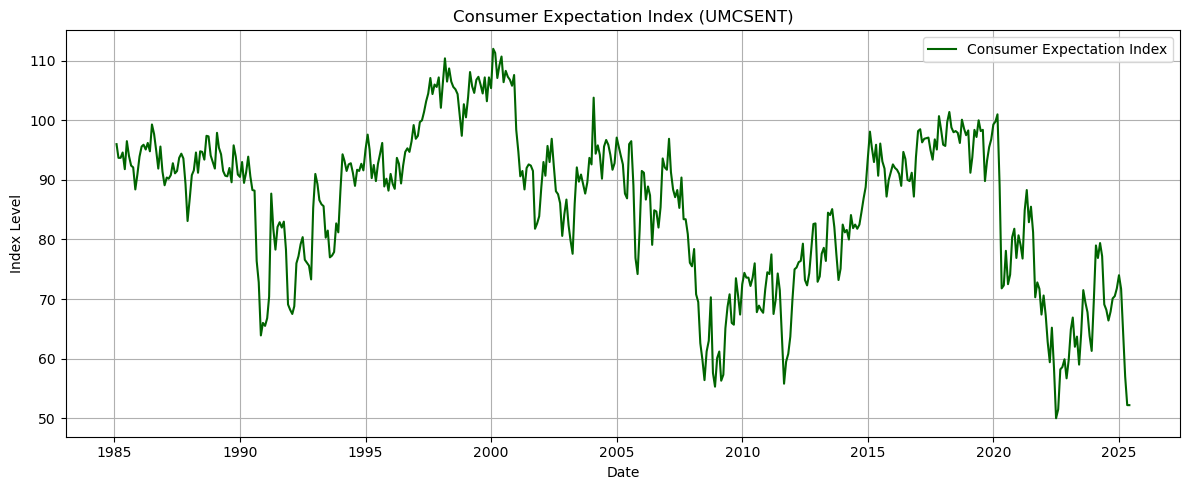

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

# === 1. 获取 UMCSENT ===
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

umcsent = pdr.DataReader('UMCSENT', 'fred', start_date, end_date)
umcsent = umcsent.resample('M').last()

# # === 2. 计算同比增速（YoY）并标准化 ===
# df = pd.DataFrame(index=umcsent.index)
# df['UMCSENT_YoY'] = umcsent.pct_change(12) * 100
# df_clean = df.dropna()
# df_std = (df_clean - df_clean.mean()) / df_clean.std()

# # === 3. 绘图 ===
# plt.figure(figsize=(12, 5))
# plt.plot(df_std.index, df_std['UMCSENT_YoY'], label='Consumer Sentiment YoY (Standardized)', color='darkgreen')
# plt.title("Standardized YoY Growth: Consumer Sentiment Index (UMCSENT)")
# plt.xlabel("Date")
# plt.ylabel("Z-score")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

# === 3. 绘图 ===
plt.figure(figsize=(12, 5))
plt.plot(umcsent.index, umcsent['UMCSENT'], label='Consumer Expectation Index', color='darkgreen')
plt.title("Consumer Expectation Index (UMCSENT)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

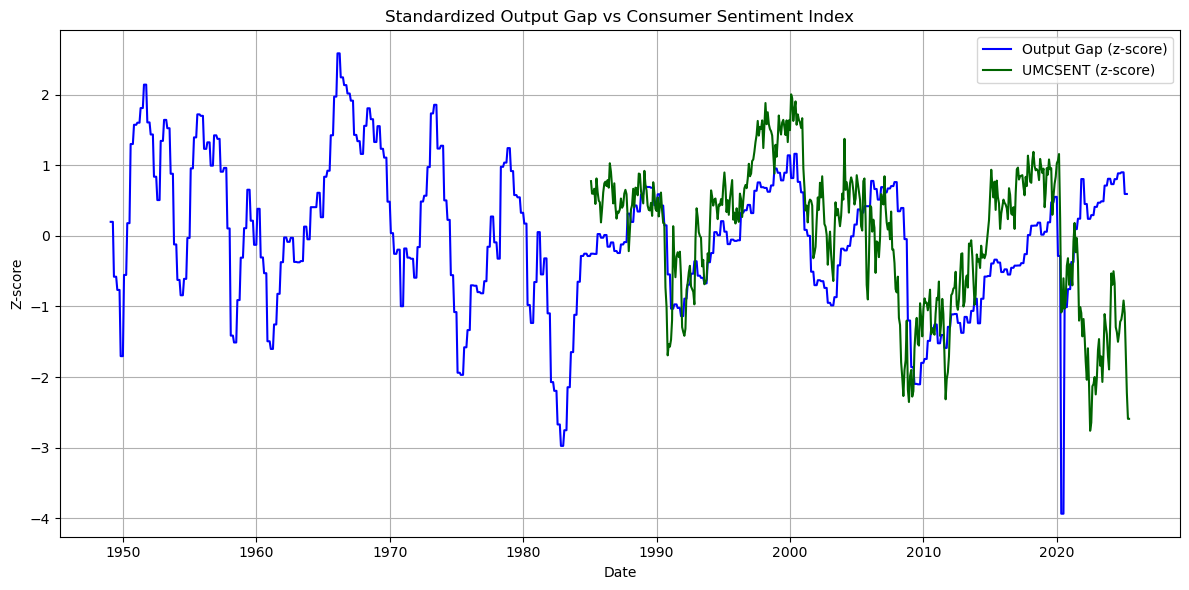

In [ ]:
# 确保 umcsent 的列名一致
umcsent.columns = ['UMCSENT']

# 合并到 df_monthly
df_monthly = df_monthly.join(umcsent, how='left')

from scipy.stats import zscore

# 只对非缺失部分做 z-score，并保持索引一致
df_monthly['UMCSENT_z'] = pd.Series(zscore(df_monthly['UMCSENT'].dropna()), 
                                    index=df_monthly['UMCSENT'].dropna().index)

df_monthly['Output_Gap_z'] = pd.Series(zscore(df_monthly['Output_Gap'].dropna()), 
                                       index=df_monthly['Output_Gap'].dropna().index)

plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Output_Gap_z'], label='Output Gap (z-score)', color='blue')
plt.plot(df_monthly.index, df_monthly['UMCSENT_z'], label='UMCSENT (z-score)', color='darkgreen')
plt.title('Standardized Output Gap vs Consumer Sentiment Index')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
import statsmodels.api as sm

# 去除缺失值
df_reg = df_monthly[['UMCSENT_z', 'Output_Gap_z']].dropna()

# 自变量（X）和因变量（Y）
X = df_reg['UMCSENT_z']
y = df_reg['Output_Gap_z']

# 添加常数项（intercept）
X = sm.add_constant(X)

# 拟合 OLS 模型
model = sm.OLS(y, X).fit()

# 打印回归结果
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Output_Gap_z   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     101.8
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           7.73e-22
Time:                        15:15:50   Log-Likelihood:                -526.86
No. Observations:                 483   AIC:                             1058.
Df Residuals:                     481   BIC:                             1066.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1544      0.033     -4.702      0.0

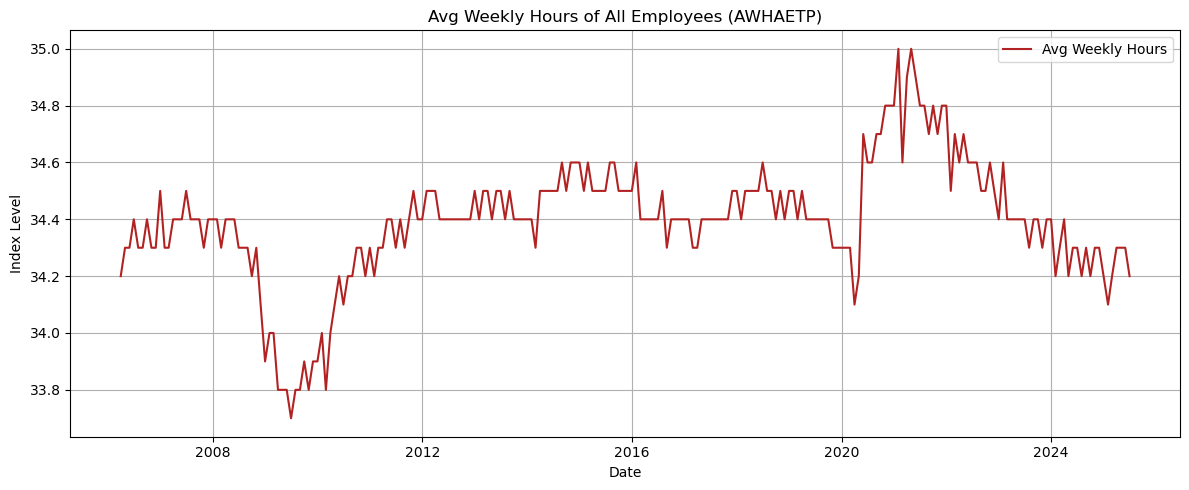

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

# === 1. 获取 AWHAETP 数据 ===
start_date = '1985-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

awh = pdr.DataReader('AWHAETP', 'fred', start_date, end_date)
awh = awh.resample('M').last()

# # === 2. 计算同比增速（YoY）并标准化 ===
# df = pd.DataFrame(index=awh.index)
# df['AWHAETP_YoY'] = awh.pct_change(12) * 100
# df_clean = df.dropna()
# df_std = (df_clean - df_clean.mean()) / df_clean.std()

# === 3. 绘图：标准化 YoY 曲线 ===
plt.figure(figsize=(12, 5))
plt.plot(awh.index, awh['AWHAETP'], label='Avg Weekly Hours', color='firebrick')
plt.title("Avg Weekly Hours of All Employees (AWHAETP)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

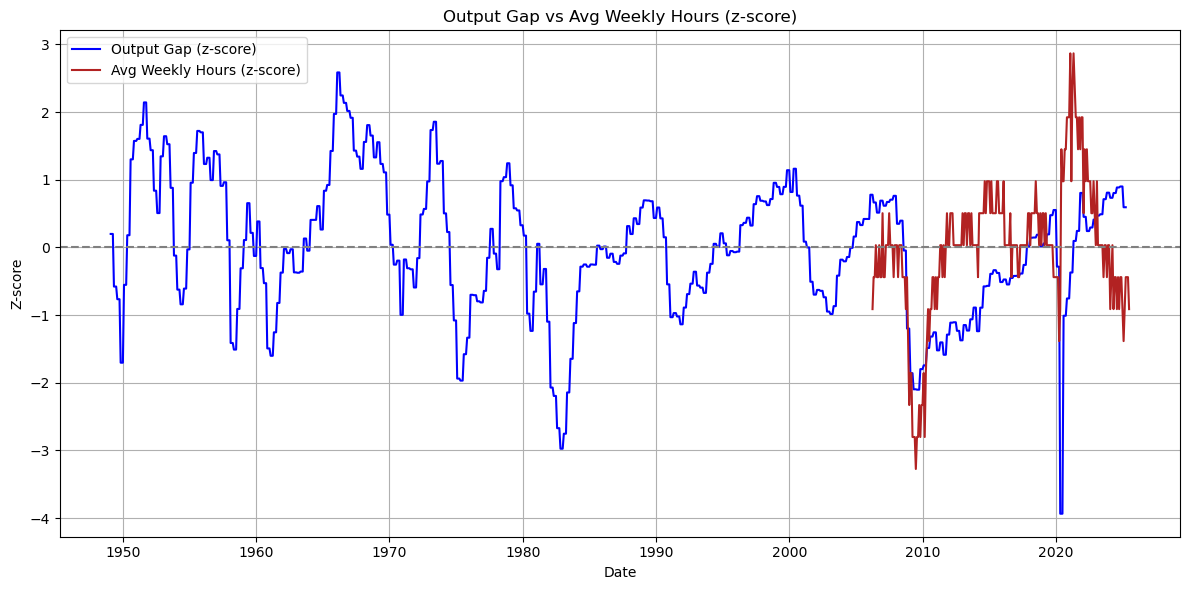

In [11]:
from scipy.stats import zscore

# 确保列名一致，防止冲突
awh.columns = ['AWHAETP']

# 合并数据（避免列重复）
if 'AWHAETP' not in df_monthly.columns:
    df_monthly = df_monthly.join(awh, how='left')

df_monthly['Output_Gap_z'] = pd.Series(zscore(df_monthly['Output_Gap'].dropna()),
                                       index=df_monthly['Output_Gap'].dropna().index)

df_monthly['AWHAETP_z'] = pd.Series(zscore(df_monthly['AWHAETP'].dropna()),
                                    index=df_monthly['AWHAETP'].dropna().index)

plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Output_Gap_z'], label='Output Gap (z-score)', color='blue')
plt.plot(df_monthly.index, df_monthly['AWHAETP_z'], label='Avg Weekly Hours (z-score)', color='firebrick')
plt.title('Output Gap vs Avg Weekly Hours (z-score)')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
import statsmodels.api as sm

# 去除缺失值
df_reg = df_monthly[['AWHAETP_z', 'Output_Gap_z']].dropna()

# 自变量（X）和因变量（Y）
X = df_reg['AWHAETP_z']
y = df_reg['Output_Gap_z']

# 添加常数项（intercept）
X = sm.add_constant(X)

# 拟合 OLS 模型
model = sm.OLS(y, X).fit()

# 打印回归结果
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           Output_Gap_z   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     20.33
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           1.05e-05
Time:                        15:15:15   Log-Likelihood:                -300.19
No. Observations:                 229   AIC:                             604.4
Df Residuals:                     227   BIC:                             611.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3655      0.060     -6.134      0.0

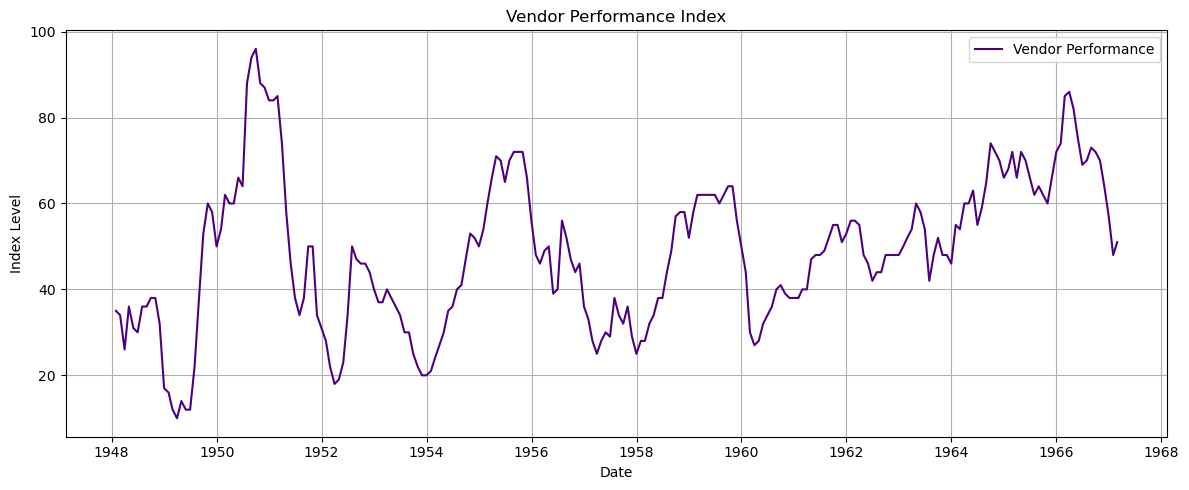

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr

# === 1. 获取 Vendor Performance 数据（单位为%）===
start_date = '1948-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

vendor = pdr.DataReader('M06006USM156NNBR', 'fred', start_date, end_date)
vendor = vendor.resample('M').last()  # 有些月份缺失，需要补成月频

# # === 2. 计算同比增速（单位已是百分比，不乘100）===
# df = pd.DataFrame(index=vendor.index)
# df['Vendor_YoY'] = vendor.pct_change(12)

# # === 3. 清洗 + 标准化 ===
# df_clean = df.dropna()
# df_std = (df_clean - df_clean.mean()) / df_clean.std()

# === 4. 绘图：标准化趋势 ===
plt.figure(figsize=(12, 5))
plt.plot(vendor.index, vendor['M06006USM156NNBR'], label='Vendor Performance', color='indigo')
plt.title("Vendor Performance Index")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# # === 5. 滞后 12 个月自相关 ===
# df_lagged = df_clean.copy()
# df_lagged['Vendor_YoY_lag12'] = df_lagged['Vendor_YoY'].shift(12)

# print("【Vendor Performance：当前与滞后12个月的自相关】")
# print(df_lagged[['Vendor_YoY', 'Vendor_YoY_lag12']].dropna().corr())


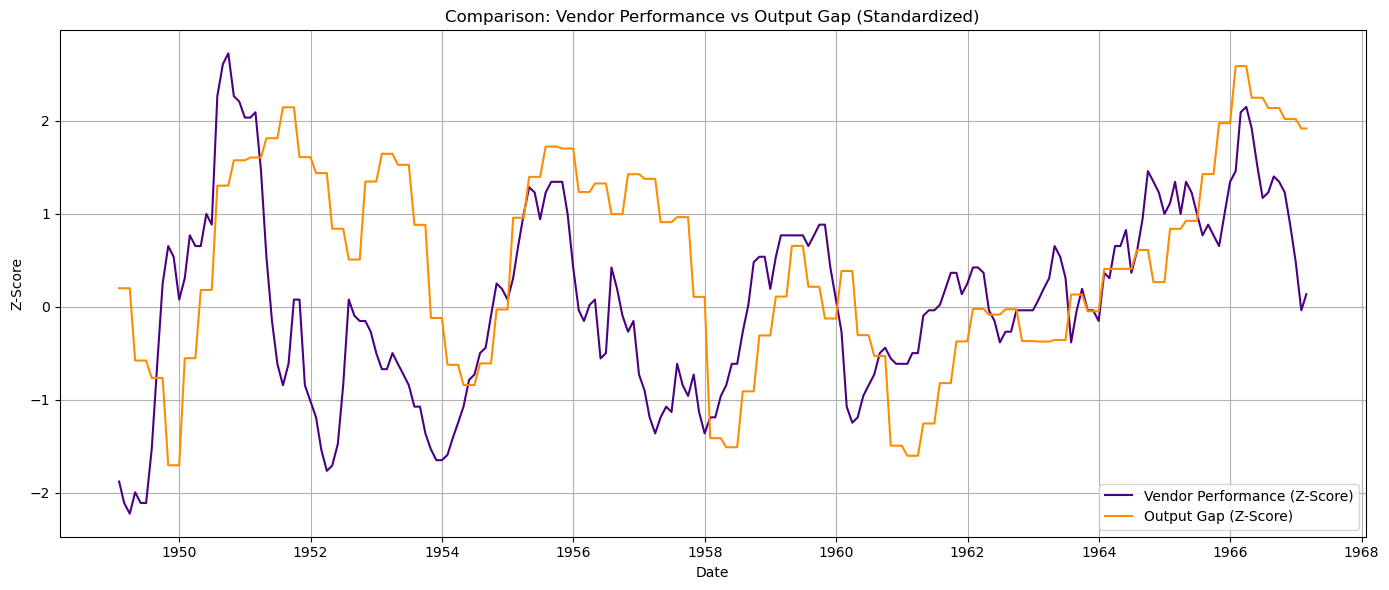

In [ ]:
vendor_clean = vendor.dropna()
vendor_clean['Vendor_z'] = zscore(vendor_clean['M06006USM156NNBR'])

output_gap = df_monthly[['Output_Gap_z']].dropna()

combined = pd.merge(vendor_clean[['Vendor_z']], output_gap, left_index=True, right_index=True, how='inner')

plt.figure(figsize=(14, 6))
plt.plot(combined.index, combined['Vendor_z'], label='Vendor Performance (Z-Score)', color='indigo')
plt.plot(combined.index, combined['Output_Gap_z'], label='Output Gap (Z-Score)', color='darkorange')
plt.title('Comparison: Vendor Performance vs Output Gap (Standardized)')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
import statsmodels.api as sm

# 1. 自变量 X（Vendor Performance）
X = combined['Vendor_z']
# 加常数项 intercept
X = sm.add_constant(X)

# 2. 因变量 Y（Output Gap）
Y = combined['Output_Gap_z']

# 3. 建立OLS模型并拟合
model = sm.OLS(Y, X).fit()

# 4. 输出回归结果摘要
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           Output_Gap_z   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     31.08
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           7.34e-08
Time:                        17:37:11   Log-Likelihood:                -307.32
No. Observations:                 218   AIC:                             618.6
Df Residuals:                     216   BIC:                             625.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4420      0.068      6.548      0.0